# FNO testbed 

In [2]:
import numpy as np
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [18]:
N = 256
train_ratio = 0.8
epochs = 1500
batch_size = 16
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# ----- Synthetic (x, y) Data -----
x = np.linspace(0, 10, N)
y = np.sin(x) + 0.1 * np.random.randn(N)
data = np.stack([x, y], axis=1)

mean = data.mean(0)
std = data.std(0)
data_norm = (data - mean) / std

# ----- Split -----
split = int(N * train_ratio)
train_data = data_norm[:split]
test_data = data_norm[split:]


In [5]:
# ----- Supervised Windowing -----
def get_sequences(data, window=10):
    X, Y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        Y.append(data[i+window])
    return np.array(X), np.array(Y)

window = 10
X_train, Y_train = get_sequences(train_data, window)
X_test, Y_test = get_sequences(test_data, window)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)


In [13]:
def spectral_conv1d(in_channels, out_channels, modes):
    def layer(x):
        B, C, L = x.shape
        x_ft = torch.fft.rfft(x, dim=-1)
        max_modes = x_ft.shape[-1]
        used_modes = min(modes, max_modes)

        weight = torch.nn.Parameter(torch.rand(in_channels, out_channels, used_modes, dtype=torch.cfloat, device=x.device))
        out_ft = torch.zeros(B, out_channels, x_ft.size(-1), dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :used_modes] = torch.einsum('bcm,com->bom', x_ft[:, :, :used_modes], weight)
        x_out = torch.fft.irfft(out_ft, n=L, dim=-1)
        return x_out

    # Note: We now return a closure that dynamically builds its own weights
    return layer, []  # no static weight needed


In [14]:
# ----- FNO1D as Functional Module -----
def fno1d_factory(input_dim=2, width=32, modes=16):
    fc1_weight = torch.nn.Parameter(torch.randn(input_dim, width) * 0.1)
    fc1_bias = torch.nn.Parameter(torch.zeros(width))

    spec_layer, spec_params = spectral_conv1d(width, width, modes)
    conv1_weight = torch.nn.Parameter(torch.randn(width, width, 1) * 0.1)
    conv1_bias = torch.nn.Parameter(torch.zeros(width))

    fc2_weight = torch.nn.Parameter(torch.randn(width, 2) * 0.1)
    fc2_bias = torch.nn.Parameter(torch.zeros(2))

    def forward(x):
        B, T, D = x.shape
        x = torch.matmul(x, fc1_weight) + fc1_bias  # [B, T, W]
        x = x.permute(0, 2, 1)  # [B, W, T]
        x1 = spec_layer(x)
        x2 = F.conv1d(x, conv1_weight, bias=conv1_bias)
        x = x1 + x2
        x = x.permute(0, 2, 1)  # [B, T, W]
        x = torch.matmul(x[:, -1], fc2_weight) + fc2_bias
        return x

    params = [fc1_weight, fc1_bias, conv1_weight, conv1_bias, fc2_weight, fc2_bias] + spec_params
    return forward, params


In [19]:
# ----- Model Init -----
fno_forward, fno_params = fno1d_factory()
optimizer = torch.optim.Adam(fno_params, lr=lr)
loss_fn = torch.nn.MSELoss()

# ----- Training Loop -----
for epoch in range(epochs):
    model_loss = 0.0
    fno_forward.train = True
    idx = torch.randperm(X_train.shape[0])

    for i in range(0, len(X_train), batch_size):
        xb = X_train[idx[i:i+batch_size]]
        yb = Y_train[idx[i:i+batch_size]]
        pred = fno_forward(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} - Loss: {model_loss:.4f}")


Epoch 0 - Loss: 7.2414
Epoch 50 - Loss: 0.6183
Epoch 100 - Loss: 0.5587
Epoch 150 - Loss: 0.3434
Epoch 200 - Loss: 0.4581
Epoch 250 - Loss: 0.3473
Epoch 300 - Loss: 0.3412
Epoch 350 - Loss: 0.3352
Epoch 400 - Loss: 0.3371
Epoch 450 - Loss: 0.3147
Epoch 500 - Loss: 0.3593
Epoch 550 - Loss: 0.3197
Epoch 600 - Loss: 0.3527
Epoch 650 - Loss: 0.3870
Epoch 700 - Loss: 0.3315
Epoch 750 - Loss: 0.4074
Epoch 800 - Loss: 0.3229
Epoch 850 - Loss: 0.3424
Epoch 900 - Loss: 0.4063
Epoch 950 - Loss: 0.3717
Epoch 1000 - Loss: 0.3527
Epoch 1050 - Loss: 0.3925
Epoch 1100 - Loss: 0.3137
Epoch 1150 - Loss: 0.3300
Epoch 1200 - Loss: 0.3469
Epoch 1250 - Loss: 0.3605
Epoch 1300 - Loss: 0.3319
Epoch 1350 - Loss: 0.3243
Epoch 1400 - Loss: 0.3419
Epoch 1450 - Loss: 0.3318


In [20]:
# ----- Autoregressive Inference -----
fno_forward.train = False
context = X_test[0:1].clone()
preds = []

for _ in range(len(Y_test)):
    with torch.no_grad():
        pred = fno_forward(context)
    preds.append(pred.cpu().numpy()[0])
    new_input = torch.cat([context[:, 1:], pred.unsqueeze(1)], dim=1)
    context = new_input


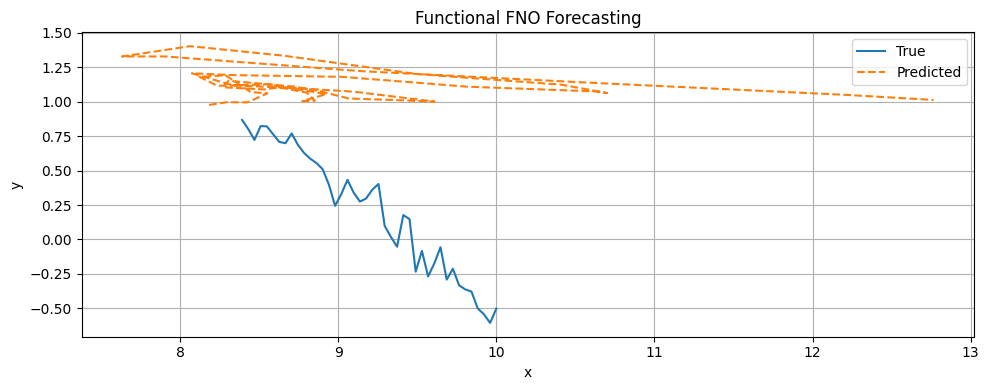

In [21]:
# ----- Denormalize and Plot -----
preds = np.array(preds)
preds_denorm = preds * std + mean
true_denorm = Y_test.cpu().numpy() * std + mean

plt.figure(figsize=(10, 4))
plt.plot(true_denorm[:, 0], true_denorm[:, 1], label='True')
plt.plot(preds_denorm[:, 0], preds_denorm[:, 1], '--', label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Functional FNO Forecasting")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
